In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..

/Users/jannes/Documents/Science/Real-Projects/P3-JP-Synapse-Paper/git-p3/learning_as_filtering_new


In [4]:
ls 

MSE_vs_input.png                 notebooks/
MSE_vs_input_tauOU100_g0.png     pkl_data/
MSE_vs_input_tauOU100_gamma.png  pull.sh
MSE_vs_input_tauOU100s.png       run_local.sh
MSE_vs_input_tauOU400_gamma.png  run_remote.sh
README.md                        src/
main.py                          util/
main.sh


- Code new learning rule
    - alpha_bar
    - x_wiggle (low pass)
- Ensure that gamma is constant
- Think of systematic comparison of Sigma in 1d
- Run on cluster for various hyperpars
    - beta
    - tau_x_wiggle
    - tau_d
    - check norm of x_eps
    - (?)
     

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import itertools as it

from src.plotting import *
from src.update_functions import *
from src.init_functions import *
from src.run_functions import *

def expspace(a0, an, n=50):
    """ linspace in exp space """
    return (a0 * np.exp(np.log(an / a0) * np.linspace(0, 1, n)))

In [6]:
p = {'t_num': 4000,
     'dt': 0.001,
     'dim':2,
     'tau':0.025,
     'g0':1,
     'beta':0.5,
     'mu_ou':0,
     'sig2_ou':1,     
     'tau_ou':1000, # s
     'rule':'corr'
    }
p['g0dt'] = p['g0']*p['dt']

# STDP
p['delta_T'] = 0.01
p['wait'] = 0.5 # s

# correlation protocol
p['correlated_times'] = np.array([0, 0.01]) # s, two spikes

# bias
p['include-bias'] = False
p['sig2_oub'] = 1
p['tau_oub'] = 0.025
p['mu_oub'] = 1.0
# spike response
p['include-spike-response-kernel'] = True
p['tau_alpha'] = 0.025
p['amplitude_alpha'] = -3/p['beta']
# single vector rules
p['tau_z'] = 1

p['tau_d'] = p['tau_ou'] # ?
p['tau_x_wiggle'] = p['tau_ou'] # good
p['compute_sig2'] = True
p['gamma_equal_g0'] = True

# performance sims:
p['epoch_num'] = 10
p['epoch_wait'] = 2
p['rate'] = 40 # Hz

Check kernel how to make a kernel constant

Text(0.5, 1.0, '0.9999999999999951')

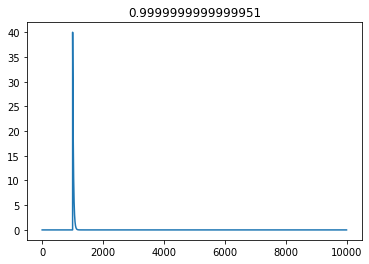

In [6]:
v = {'x': np.zeros(10000)}
dt = 0.001
p['tau'] = 0.025
eps0 = 1/p['tau']
for k in range(10000-1):
    Sx = int(k == 1000)
    v['x'][k + 1] = (1 - dt / p['tau']) * v['x'][k] + Sx*eps0
plt.plot(v['x'])
plt.title(str(dt*sum(v['x'])))

Performance simulation for two values of the membrane time constant

In [7]:
p['tau_ou'] = 4
p['tau_d'] = 1
p['tau_x_wiggle'] = 1
p['beta'] = 0.02
p['dim'] = 1
p['dt'] = 0.001

p['include-spike-response-kernel'] = False
p['include-bias'] = False

p['tau'] = 0.025
p['rule'] = 'exp-rm2'
out,v = run_simulation(p,verbose=True,online=False)

p['tau'] = 1
p['rule'] = 'exp-rm2'
out,v2 = run_simulation(p,verbose=True,online=False)

0.9872826111874329
0.9381324938391181


Text(0.5, 1.0, 'Overall activation only driven by rate, not tau_m')

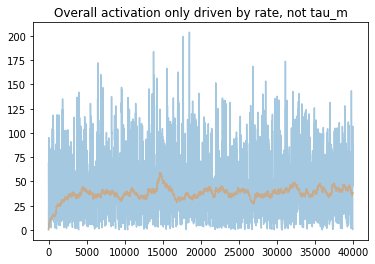

In [8]:
plt.plot(v['x'], alpha=0.4)
print(np.mean(v['x'])/p['rate'])
plt.plot(v2['x'], alpha=0.4)
print(np.mean(v2['x'])/p['rate'])
plt.title('Overall activation only driven by rate, not tau_m')

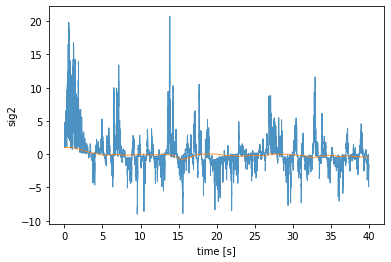

In [9]:
vplt(v,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
vplt(v2,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)

Performance simulation for two learning rules
- show limiting case of tau >> 1, both rules yield the same

In [103]:
p['tau_ou'] = 1
p['tau_d'] = 2  # should not matter here
p['tau_x_wiggle'] = 10 # should not move and represent some equilibrium approx.
p['beta'] = 0.005
p['dim'] = 1
p['dt'] = 0.001
p['epoch_num'] = 100

p['include-spike-response-kernel'] = False
p['include-bias'] = False

p['tau'] = 2
p['rule'] = 'corr'
out,v = run_simulation(p,verbose=True,online=False)

p['rule'] = 'exp-rm2'
out,v2 = run_simulation(p, verbose=True, online=False, precomputed_generator=v)

loaded precomputed values for: ['Sx', 'y', 'w', 'g']


tau_ou=1, tau_d=2, beta=1/200, tau_m=2


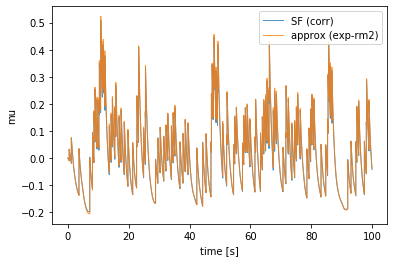

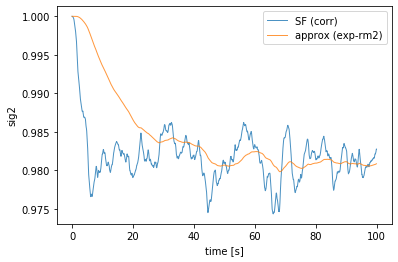

In [107]:
print('tau_ou=1, tau_d=2, beta=1/200, tau_m=2')

vplt(v,p,key='mu',dim=0,cut=1,c=None,err=True,alpha=0.8)
vplt(v2,p,key='mu',dim=0,cut=1,c=None,err=True,alpha=0.8)
plt.legend(['SF (corr)','approx (exp-rm2)'])

#plt.show(), plt.close()

#vplt(v,p,key='x',dim=0,cut=1,c=None,err=True,alpha=0.8)
#vplt(v2,p,key='x',dim=0,cut=1,c=None,err=True,alpha=0.8)
#plt.legend(['corr','exp-rm2'])

plt.show(), plt.close()

vplt(v,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
vplt(v2,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
plt.legend(['SF (corr)','approx (exp-rm2)'])

Performance simulation for two learning rules
- show limiting case of tau << 1, both rules yield the same?

In [109]:
p['tau_ou'] = 1
p['tau_d'] = 1  # should not matter here
p['tau_x_wiggle'] = 10 # should not move and represent some equilibrium approx.
p['beta'] = 0.005
p['dim'] = 1
p['dt'] = 0.001
p['epoch_num'] = 100

p['include-spike-response-kernel'] = False
p['include-bias'] = False

p['tau'] = 0.01
p['rule'] = 'corr'
out,v = run_simulation(p,verbose=True,online=False)

p['rule'] = 'exp-rm2'
out,v2 = run_simulation(p, verbose=True, online=False, precomputed_generator=v)

loaded precomputed values for: ['Sx', 'y', 'w', 'g']


tau_ou=1, tau_d=1, beta=1/200, tau_m=0.01


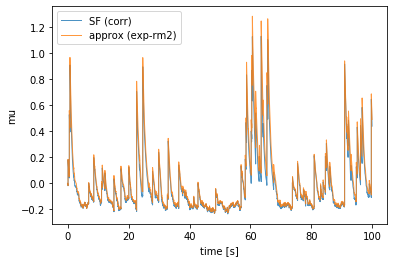

Variance values do not coincide


(0.8, 1.2)

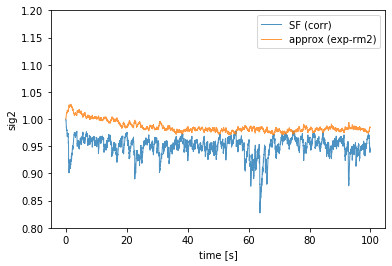

In [111]:
print('tau_ou=1, tau_d=1, beta=1/200, tau_m=0.01')
vplt(v,p,key='mu',dim=0,cut=1,c=None,err=True,alpha=0.8)
vplt(v2,p,key='mu',dim=0,cut=1,c=None,err=True,alpha=0.8)
plt.legend(['SF (corr)','approx (exp-rm2)'])
#plt.ylim([0,None])

plt.show(), plt.close()

#vplt(v,p,key='x',dim=0,cut=1,c=None,err=True,alpha=0.8)
#vplt(v2,p,key='x',dim=0,cut=1,c=None,err=True,alpha=0.8)
#plt.legend(['corr','exp-rm2'])

#plt.show(), plt.close()

print('Variance values do not coincide')
vplt(v,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
vplt(v2,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
plt.legend(['SF (corr)','approx (exp-rm2)'])
plt.ylim([0.8,1.2])


In [101]:
import scipy.stats as stats
s=v['sig2'].reshape(-1)
s2=v2['sig2'].reshape(-1)
stats.pearsonr(s,-s2)

(0.2389516546927042, 0.0)

(-0.23895165469270419, 0.0)

In [77]:
# mean of sigma is off
# variance of sigma is off

In [39]:
def metric(x,y):
    return 2*x*y/(x**2 + y**2)

In [40]:
import itertools as it
xs,ys = np.linspace(0.1,2), np.linspace(0.1,2)
z = [metric(x,y) for (x, y) in it.product(xs,ys)]

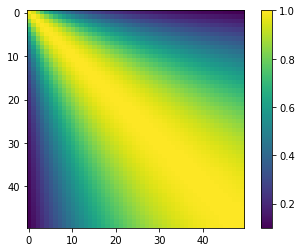

In [45]:
z = np.array(z).reshape([len(xs), len(ys)])
h = plt.imshow(z)
plt.colorbar(h)

Performance sims for multiple time constants on a grid

In [ ]:
p['tau_ou'] = 4
tau_ds = [0.1,0.5,1]
tau_x_wiggles = [1,1.5,2]
f, axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=[10,10])
for ax, (tau_d, tau_x_wiggle) in zip(
    axs.reshape(-1), it.product(tau_ds, tau_x_wiggles)):

    p['tau_d'] = tau_d*p['tau_ou']
    p['tau_x_wiggle'] = tau_x_wiggle*p['tau_ou']
    p['beta'] = 0.02
    p['dim'] = 1
    p['dt'] = 0.001

    p['include-spike-response-kernel'] = False
    p['include-bias'] = False

    p['rule'] = 'exp-rm2'
    out,v = run_simulation(p,verbose=True,online=False)

    p['rule'] = 'corr'
    out,v2 = run_simulation(p,verbose=True,online=False)

    plt.sca(ax)
    vplt(v,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
    vplt(v2,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
    
    tau_dd = p['tau_d']
    tau_x_wigglee = p['tau_x_wiggle']
    plt.title(f'tau_d={tau_dd}, tau_x_wiggle={tau_x_wigglee}')
    
plt.show(), plt.close()

With larger beta

In [ ]:
p['tau_ou'] = 4
tau_ds = [0.1,0.5,1]
tau_x_wiggles = [0.1,0.5,1]
f, axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=[10,10])
for ax, (tau_d, tau_x_wiggle) in zip(
    axs.reshape(-1), it.product(tau_ds, tau_x_wiggles)):

    p['tau_d'] = tau_d*p['tau_ou']
    p['tau_x_wiggle'] = tau_x_wiggle*p['tau_ou']
    p['beta'] = 0.1
    p['dim'] = 1
    p['dt'] = 0.001

    p['include-spike-response-kernel'] = False
    p['include-bias'] = False

    p['rule'] = 'exp-rm2'
    out,v = run_simulation(p,verbose=True,online=False)

    p['rule'] = 'corr'
    out,v2 = run_simulation(p,verbose=True,online=False)

    plt.sca(ax)
    vplt(v,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
    vplt(v2,p,key='sig2',dim=0,cut=1,c=None,err=True,alpha=0.8)
    
    tau_dd = p['tau_d']
    tau_x_wigglee = p['tau_x_wiggle']
    plt.title(f'tau_d={tau_dd}, tau_x_wiggle={tau_x_wigglee}')
    
plt.show(), plt.close()

Plot Sigma_infty with errorbars as function of beta:

In [ ]:
#10*63000/3600 # hours

In [ ]:
p['tau_ou'] = 4
p['tau_d'] = 4
p['tau_x_wiggle'] = 6
p['beta'] = 0.1
p['dim'] = 1
p['dt'] = 0.001
p['epoch_num'] = 30
p['include-spike-response-kernel'] = False
p['include-bias'] = False
p['compute_sig2'] = True # for plotting?
p['online'] = True

mp = {'betas': [p['beta']], #np.linspace(0.01,1,21),
      'rules':  ('corr','exp','exp-rm2'),
      'repeats': range(20),
      #'dims': [1,2,3,4,5,7,9,11,13,15,20,25,30,40,50],
      'dims': [1,10,50],
      'tau': [0.005, 0.025,0.125, 0.625]              
      }
res = []

parameter_list = list(enumerate(it.product(mp['dims'], mp['betas'],
                                        mp['rules'], mp['repeats'],
                                        mp['tau']
                                        )))
        
length = len(parameter_list)
#length = len(list(it.product(mp['betas'], mp['rules'], mp['repeats'])))
#res = []

#parameter_list = list(enumerate(it.product(mp['betas'],
 #                                               mp['rules'], mp['repeats'], mp['dims'])))

#parameter_list = list(enumerate(it.product(mp['betas'], mp['rules'], mp['repeats'])))

for count, (dim, beta, rule, repeat, tau) in parameter_list:    
    print(count,'/',length,'rule:',rule,'beta:',beta)
    p['rule'] = rule
    p['beta'] = beta
    p['tau'] = tau
    
    out,v = run_simulation(p,verbose=True,online=True)
    
    out = out.mean().to_dict()
    out.update({'beta':beta,'rule':rule})       
    res.append(out)
res = pd.DataFrame(res)

In [ ]:
len(parameter_list)

In [12]:
def plot_res(res, metrics = ['MSE','sig2'],ylims=None, xaxis='beta'):
    res2 = res[['rule',xaxis] + metrics]
    mean = res2.groupby(['rule',xaxis]).mean()
    sem = res2.groupby(['rule',xaxis]).sem()

    f,axs = plt.subplots(len(metrics),1,figsize=[8,6], tight_layout=True,sharex=True)
    for metric,ax in zip(metrics,axs.reshape(-1)):
        ax.set_ylabel(metric)

        for rule in mp['rules']:
            mean.loc[rule,metric].plot(label=rule,ax=ax,marker='o',yerr=sem.loc[rule,metric])
            
        if ylims is not None:
            ax.set_ylim(ylims[metric])
            
        ax.legend(ncol=len(mp['rules']))
        #ax.set_xscale('log')
        ax.set_title(metric)
        #ax.set_yscale('log')
        

In [15]:
ls ./../c_12-Apr-2021-int_tau_const_mini2

c_01-Mar-2021-beta_lin_dim/
c_03-Mar-2021-beta_lin_dim/
c_07-Feb-2021-job_name/
c_07-Mar-2021-beta_lin_dim2/
c_08-Feb-2021-beta100/
c_08-Mar-2021-beta_lin_dim3/
c_11-Apr-2021-int_tau_const/
c_11-Apr-2021-int_tau_const_mini/
c_12-Apr-2021-int_tau_const_mini2/
c_14-Mar-2021-beta_lin_dim3/
c_14-Mar-2021-low_high_tau_x_rho/
c_14-Mar-2021-low_high_tau_x_rho2/
c_14-Mar-2021-low_high_tau_x_rho3/
c_15-Mar-2021-low_high_tau_x_rho3_long/
c_20-Mar-2021-low_high_tau_x_rho3_long_gamma/
c_20-Mar-2021-low_high_tau_x_rho3_longlong/
c_21-Mar-2021-low_high_tau_x_rho3_long_beta_smaller/
c_21-Mar-2021-low_high_tau_x_rho3_long_beta_smaller_g0/
c_21-Mar-2021-low_high_tau_x_rho3_longlong2/
c_22-Apr-2021-int_tau_const_mini2/
c_22-Feb-2021-beta100/
c_22-Feb-2021-beta_lin/
c_28-Feb-2021-beta_lin/
c_30-Mar-2021-low_high_tau_x_rho3_long_beta_smaller_g0/
learning_as_filtering/
learning_as_filtering_new/


In [7]:
from pathlib import Path
#file_path = Path('./../c_28-Feb-2021-beta_lin/pkl_data/')
#file_path = Path('./../c_07-Mar-2021-beta_lin_dim2/pkl_data/')
file_path = Path('./../c_14-Mar-2021-low_high_tau_x_rho3/pkl_data/')
#file_path = Path('./../c_15-Mar-2021-low_high_tau_x_rho3_long/pkl_data/')
#file_path = Path('./../c_20-Mar-2021-low_high_tau_x_rho3_longlong/pkl_data/')
#file_path = Path('./../c_20-Mar-2021-low_high_tau_x_rho3_long_gamma/pkl_data/') -> instable
#file_path = Path('./../c_21-Mar-2021-low_high_tau_x_rho3_long_beta_smaller_g0/pkl_data/') # -> beta 0.1, g0: not unstable, but worse MSE
#file_path = Path('./../c_21-Mar-2021-low_high_tau_x_rho3_long_beta_smaller/pkl_data/') # -> beta 0.1, gamma: unstable but a bit later
#file_path = Path('./../c_21-Mar-2021-low_high_tau_x_rho3_longlong2/pkl_data/') # -> tau_ou=300s, g0: unstable
#file_path = Path('./../c_12-Apr-2021-int_tau_const_mini2/pkl_data/') 

# Qs:
# g0 vs gamma
# long vs short

import pickle
def load_obj(name, path='./'):
    #    print('load obj:',os.getcwd())
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
res3 = pd.concat([load_obj(str(path)[:-4]) for path in file_path.glob('**/*.pkl')])

In [9]:
res3[(res3.dim==1) & (res3.rule == 'corr')]

,L,L_pt,MSE,beta,count,dim,gbar_gg_one,gdt_gg_one,gmap_gg_one,rule,tau,tau_rho
0,-8.039121e-07,-0.000001,0.870255,0.3,270,1,0.0,0.0,0.0,corr,0.005,0.2
1,-5.105533e-06,-0.000001,0.689412,0.3,271,1,0.0,0.0,0.0,corr,0.010,0.4
2,-4.405155e-06,-0.000008,0.578141,0.3,272,1,0.0,0.0,0.0,corr,0.015,0.6
3,2.453117e-05,0.000015,0.858953,0.3,273,1,0.0,0.0,0.0,corr,0.020,0.8
4,1.509860e-05,0.000010,0.668054,0.3,274,1,0.0,0.0,0.0,corr,0.025,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10,3.322442e-04,0.000304,0.383828,0.3,250,1,0.0,0.0,0.0,corr,0.060,2.4
11,6.840184e-04,0.000597,0.462031,0.3,251,1,0.0,0.0,0.0,corr,0.070,2.8
12,1.233935e-03,0.001176,0.483397,0.3,252,1,0.0,0.0,0.0,corr,0.080,3.2
13,9.386932e-05,0.000076,0.397844,0.3,253,1,0.0,0.0,0.0,corr,0.090,3.6


low high analysis

In [10]:
res = res3.copy()
res

,L,L_pt,MSE,beta,count,dim,gbar_gg_one,gdt_gg_one,gmap_gg_one,rule,tau,tau_rho
0,0.000001,4.343577e-07,0.973556,0.3,1395,10,0.0,0.0,0.0,exp,0.005,0.2
1,0.000002,-3.432604e-07,1.102396,0.3,1396,10,0.0,0.0,0.0,exp,0.010,0.4
2,-0.000001,2.173107e-06,1.052352,0.3,1397,10,0.0,0.0,0.0,exp,0.015,0.6
3,0.000031,2.377695e-05,0.986663,0.3,1398,10,0.0,0.0,0.0,exp,0.020,0.8
4,0.000010,1.027622e-05,0.982682,0.3,1399,10,0.0,0.0,0.0,exp,0.025,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.000078,6.167943e-05,0.907198,0.3,1135,10,0.0,0.0,0.0,corr,0.060,2.4
11,0.000124,9.718872e-05,0.945477,0.3,1136,10,0.0,0.0,0.0,corr,0.070,2.8
12,0.000083,6.365856e-05,0.888491,0.3,1137,10,0.0,0.0,0.0,corr,0.080,3.2
13,0.000813,7.856069e-04,0.908616,0.3,1138,10,0.0,0.0,0.0,corr,0.090,3.6


In [11]:
m = res.groupby(['rule','tau','dim']).mean().reset_index()
m2 = m[m.tau != .625].sort_values('count').set_index('tau_rho')

Text(0.5, 1.05, 'MSE vs dimensionless input strength (firing rate time membrane constant)')

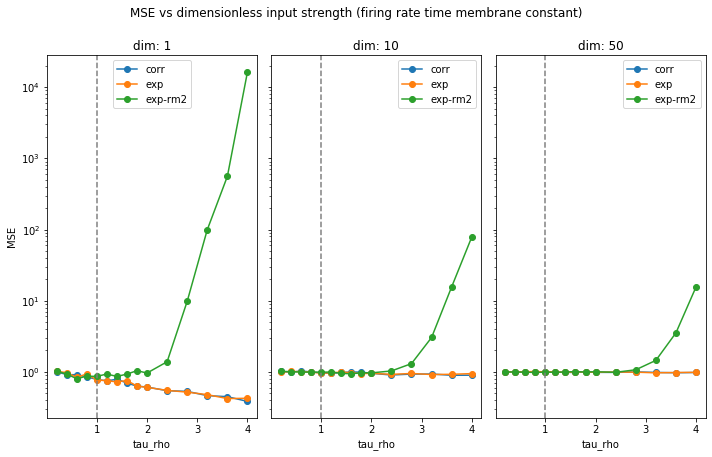

In [12]:
f,axs = plt.subplots(1,3,figsize=[10,6],tight_layout=True,sharey=True)
for dim,ax in zip(m2.dim.unique(),axs):
    m3 = m2.loc[m2.dim==dim,['rule','MSE']]
    #ax = None
    for rule in m3.rule.unique():
        ax = m3[m3.rule==rule].plot(y='MSE',label=rule,ax=ax,marker='o')
    ax.axvline(x=1, ls='--', c='gray')
    ax.set_title('dim: ' + str(dim))    
    #ax.set_ylim([0.0,1.5])
    if axs[0] is ax:
        ax.set_ylabel('MSE')
    #ax.set_xticks(m2.index.drop_duplicates())
    ax.set_yscale('log')
plt.suptitle('MSE vs dimensionless input strength (firing rate time membrane constant)',y=1.05)
#plt.savefig('MSE_vs_input_tauOU400_gamma.png',dpi=500)

dim beta analysis

In [13]:
res = res3

In [14]:
#plot_res(res3, metrics=['MSE','L'], ylims={'MSE':(0.6,1.1), 'sig2':(0,1.1) }, xaxis='dim')
metrics = ['MSE','L']
#def plot_res(res, metrics = ['MSE','sig2'],ylims=None, xaxis='beta'):
xaxis='dim'
res2 = res[['rule',xaxis] + metrics]
mean = res2.groupby(['rule',xaxis]).mean()
sem = res2.groupby(['rule',xaxis]).sem()

In [15]:
mean

MSE         L
rule    dim                       
corr    1       0.688128  0.000574
        10      0.962749  0.000328
        50      0.989345  0.000314
exp     1       0.693786  0.000629
        10      0.964057  0.000298
        50      0.993659  0.000255
exp-rm2 1    1136.546422  0.000000
        10      7.282565  0.000000
        50      2.174615  0.000000

NameError: name 'mp' is not defined

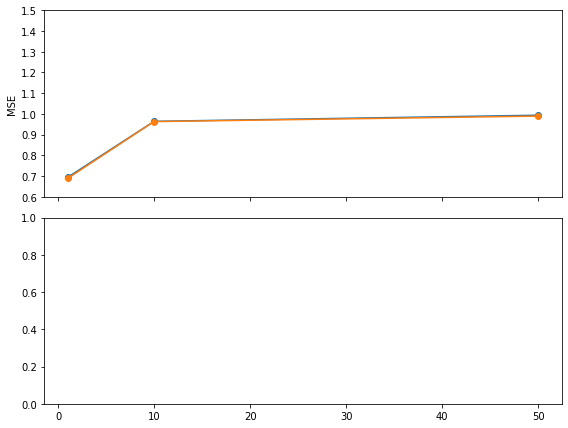

In [16]:
ylims={'MSE':(0.6,1.5), 'L':(-0.1,0.1) }
f,axs = plt.subplots(len(metrics),1,figsize=[8,6], tight_layout=True,sharex=True)
for metric,ax in zip(metrics,axs.reshape(-1)):
    ax.set_ylabel(metric)

    for rule in ['exp', 'corr','exp-rm2']:
        mean.loc[rule,metric].plot(label=rule,ax=ax,marker='o',yerr=sem.loc[rule,metric])

    if ylims is not None:
        ax.set_ylim(ylims[metric])

    ax.legend(ncol=len(mp['rules']))
    ax.set_title(metric)

Insights:
- exp-rm2 has no loglike because of gamma = g0
- without beta scaling, high dim values wont work
- all corr-sims were killed (probably because they contained a dim=100 case)

Mitigation:
- focus on dim only
- scale beta

Test limiting cases:
- x=const
- x=super stocastic
- => run and compare both rules for both cases, four in total
 

Old stuff

In [ ]:
i_max = 100
i = 0
mp = {'betas': [p['beta']], #np.linspace(0.01,1,21),
      'rules':  ('corr','exp','exp-rm2'),
      'repeats': range(5),
      'dims': [1, 5, 10, 50, 100]}
res = []

parameter_list = list(enumerate(it.product(mp['betas'], mp['rules'], mp['repeats'], mp['dims'])))
length = len(parameter_list)

def assign_parameters_to_maximally_imax_nodes(i_max, i, parameter_list):
    num_pars = len(parameter_list)
    ii_to_run = np.where(np.arange(num_pars)[[int(ii/(num_pars/i_max)) for ii in range(num_pars)]] == i)[0]
    parameter_list_to_run = [parameter_list[ii] for ii in ii_to_run]
    return parameter_list_to_run


if i != -1:
    # maximally i_max sims
    if len(parameter_list) < i_max + 1:
        parameter_list = [parameter_list[i]]
    else:
        parameter_list = assign_parameters_to_maximally_imax_nodes(
                        i_max=i_max, i=i, parameter_list=parameter_list)
parameter_list

In [ ]:
res = pd.DataFrame(res)
plot_res(res3,['MSE','sig2','L'])

In [ ]:
res[res.rule=='corr']

Older stuff

In [ ]:
A = p['sig2_ou']*p['beta']**2*p['g0dt']/p['dt']*p['tau_ou']/2
out.mean()

In [ ]:
f,axs = plt.subplots(p['dim'],1,figsize=[12,10])
for dim,ax in zip(range(p['dim']),axs.reshape(-1)):
    plt.sca(ax)
    vplt(v,p,key='filter',dim=dim,cut=1,c=None,err=True,alpha=0.8)

In [ ]:
parameter_list = list(enumerate(it.product(mp['betas'], mp['rules'], mp['repeats'])))
def assign_parameters_to_maximally_imax_nodes(i_max, i, parameter_list):
    num_pars = len(parameter_list)
    ii_to_run = np.where(np.arange(num_pars)[[int(ii/(num_pars/i_max)) for ii in range(num_pars)]] == i)[0]
    parameter_list_to_run = [parameter_list[ii] for ii in ii_to_run]
    return parameter_list_to_run
i_max = 100
i = 4

In [ ]:
assign_parameters_to_maximally_imax_nodes(i_max,i,parameter_list)

In [ ]:
len(parameter_list)

In [ ]:
p['tau_ou'] = 5*20
p['tau_z'] = 5*20
p['beta'] = 0.1
p['dim'] = 1
p['dt'] = 0.001
p['epoch_num'] = 50 # 2 * 2 * 5 = 20
p['include-spike-response-kernel'] = False
p['include-bias'] = False

mp = {'betas': expspace(0.001,0.3,5*2),
      'rules':  ('corr','exp','exp-rm2') , # ('exp','corr','exp-oja','exp-rm'), 
      'repeats': range(20)}
length = len(list(it.product(mp['betas'], mp['rules'], mp['repeats'])))
res = []


parameter_list = list(enumerate(it.product(mp['betas'], mp['rules'], mp['repeats'])))

for count, (beta, rule, repeat) in parameter_list:    
    print(count,'/',length,'rule:',rule,'beta:',beta)
    p['rule'] = rule
    p['beta'] = beta
    out,v = run_simulation(p,verbose=True,online=True)
    out = out.mean().to_dict()        
    
    # what about diag vs matrix??? corr vs exp-rm2
    mean = np.mean(v['sig2'][k0:k])
    std = np.std(v['sig2'][k0:k])
            
    print(rule,mean,std)
    
    out.update({'beta':beta,'rule':rule})                
    out.update({'Sigma_mean': mean})
    out.update({'Sigma_std': std})
    out.update({'alpha_bar': A3})
    
    
    res.append(out)    
res = pd.DataFrame(res)

In [ ]:
v

In [ ]:
import sys, os
from util.util import load_obj

In [ ]:
path = '../c_08-Feb-2021-beta100/pkl_data/'
dfs = []
for file in [file for file in os.listdir(path) if 'pkl' in file[-4:]]:
    dfs.append(load_obj(path + file[:-4]))
dfs = pd.concat(dfs)

In [ ]:
def assign_parameters_to_maximally_imax_nodes(i_max, i, parameter_list):
    num_pars = parameter_list
    ii_to_run = np.where(np.arange(num_pars)[[int(ii/(num_pars/i_max)) for ii in range(num_pars)]] == i)[0]
    parameter_list_to_run = [parameter_list[ii] for ii in ii_to_run]
    return parameter_list_to_run

In [ ]:
res = dfs.copy()
res

In [ ]:
### eval sigma

In [ ]:
res2 = res.drop(list(res.columns)[1:6],axis=1)
mean = res2.groupby(['rule','beta']).mean()
sem = res2.groupby(['rule','beta']).sem()

f,axs = plt.subplots(4,1,figsize=[12,10])
for metric,ax in zip(('MSE','Sigma_mean','Sigma_std','alpha_bar'),axs.reshape(-1)):
    ax.set_ylabel(metric)
    
    # fix
#    if 'L' in metric:
 #       ax.set_ylim([-0.00000001,0.00000001])
     #   mean[metric] += 1
                    
    for rule in mp['rules']:
        #if ((rule != 'corr') and (metric != 'alpha_bar')):     
        mean.loc[rule,metric].plot(label=rule,ax=ax,marker='o',yerr=sem.loc[rule,metric])
    ax.legend(ncol=len(mp['rules']))
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    

### eval performance

In [ ]:
res2 = res.sort_values('count').drop(list(res.columns)[3:6],axis=1)

res2 = res2[res2.beta < 0.1]

mean = res2.groupby(['rule','beta']).mean()
sem = res2.groupby(['rule','beta']).sem()

f,axs = plt.subplots(1,3,figsize=[12,6], tight_layout=True)
for metric,ax in zip(('MSE','L','L_pt'),axs.reshape(-1)):
    ax.set_ylabel(metric)
    
    # fix
    if 'L' in metric:
        #ax.set_ylim([-0.00000001,0.00000001])
        unit = 10**6
        mean[metric] *= unit
        sem[metric] *= unit
    #for rule in ['corr','exp']:
    for rule in mp['rules']:
        mean.loc[rule,metric].plot(label=rule,ax=ax,marker='o',yerr=sem.loc[rule,metric])
    ax.legend() #ncol=len(mp['rules']))
    ax.set_xscale('log')
    #ax.set_yscale('log')
f.suptitle(r'Parameters: $T_{\max}=50 \tau_{ou}, \tau_{ou} = \tau_{z} = 100s, d=1, n_{sim} = 20$', y=1.05)
    

What did I learn from this?
1. I can run on cluster again. Good.
2. Probably multiple tau_z = 100s are needed.
3. Probably more averaging is needed.
4. Very small beta is not meaningful, zoom into the range.
5. be less verbose in output
6. g0 vs gamma_approx
7. check sigma_t vs sigma_approx_t -> quantify the difference between the true and false?

# STDP / Heterosynaptic plasticity 

In [ ]:
mp = {'num_delta_T':21,
      'delta_T_max':0.1,
      'delta_T_min':-0.1}

Compare two rules for single time series

In [ ]:
test_rule = 'exp-rm'
p['rule'] = test_rule
p['delta_T'] = 0.1
p['dim'] = 1
v, states = run_timeseries(p,hetero=False)

p['rule'] = 'corr'
v2, states = run_timeseries(p,hetero=False)

#p['rule'] = 'corr'
#v2, states = run_timeseries(p,hetero=False)

In [ ]:
fig, axs = plt.subplots(2,2,tight_layout=True, sharex=True)
plt.sca(axs[0,0])
vplt(v,p,'mu',0) #, plt.xlim([0.45,.55])
plt.title('deltaT={0}, dim={1}, beta={2}'.format(p['delta_T'],p['dim'],p['beta']))
plt.sca(axs[0,1])

vplt(v2,p,'mu',0,c='red') #, plt.xlim([0.45,.55])
plt.title('deltaT={0}, dim={1}, beta={2}'.format(p['delta_T'],p['dim'],p['beta']))

plt.sca(axs[1,0])
vplt(v,p,'sig2',0) #, plt.xlim([0.45,.55])
#plt.title('sig2(t) and z(t)')
plt.ylabel('z(t)')
plt.sca(axs[1,1])
vplt(v2,p,'sig2',0,c='red') #, plt.xlim([0.45,.55])
#plt.title('sig2(t) and z(t)')
#plt.gca().legend(['exp-z','corr'])

Compare STDP protocol for two rules

In [ ]:
p['dim'] = 1
p['rule'] = test_rule
out = run_STDP(mp,p)
p['rule'] = 'corr'
out2 = run_STDP(mp,p)

In [ ]:
d = 0
def plt_stdp(out,d=0,c='k'):
    xplt, dmu = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out]).T
    plt.plot(xplt,dmu,c=c)
    plt.title('beta={0}, rule={1}'.format(p['beta'],p['rule']))

fig, axs = plt.subplots(1,2,tight_layout=True)
plt.sca(axs[0])
p['rule'] = test_rule
plt_stdp(out)
p['rule'] = 'corr'
plt.sca(axs[1])
plt_stdp(out2,c='red')
#plt.gca().legend(['exp-z','corr'])

In [ ]:
p['rule'] = 'corr' # SF
p['dim'] = 2
v, states = run_timeseries(p,hetero=True)
out = run_STDP(mp,p,hetero=True)

p['rule'] = test_rule
v2, states = run_timeseries(p,hetero=True)
out2 = run_STDP(mp,p,hetero=True)

In [ ]:
A = p['beta']**2*(p['g0dt']/p['dt'])*p['tau_ou'] # OK 
A

In [ ]:
fig, axs = plt.subplots(1,2,tight_layout=True)
for i, out_i, rule in zip([0,1],[out,out2],['corr',test_rule] ):
    plt.sca(axs[i])
    d = 0
    xplt, dmu = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out_i]).T
    d = 1
    xplt, dmu2 = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out_i]).T
    plt.plot(xplt,dmu,c='k',lw=1,label='Syn 1')
    plt.plot(xplt,dmu2,c='red',lw=1,label='Syn 2')
    plt.gca().legend()
    plt.title('Hetero {1} b={0}'.format(p['beta'],rule))
